In [1]:
# Imports
import pandas as pd
import dask.dataframe as dd
import numpy as np
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
# Loads reviews dataframe
df_reviews = dd.read_parquet("../../data/reviews.parquet").compute()

In [3]:
# Subset reviews dataframe to relevant columns
df_reviews = df_reviews[["author_steamid", "steam_appid", "voted_up"]]
df_reviews.head()

,author_steamid,steam_appid,voted_up
recommendationid,,,
92426316,76561197991126058,1000000,True
92738312,76561198043369921,1000000,True
95149549,76561198308633526,1000000,False
116584366,76561197990036156,1000000,False
129441214,76561198281676677,1000000,False


In [4]:
# Loads game info
df_games = pd.read_parquet("../../data/store_info.parquet")

# Adds game name to reviews dataframe.
# Index is reset and then set because pandas.DataFrame.merge removes the index otherwise
df_reviews = (
    df_reviews.reset_index(drop=False)
    .merge(df_games[["name"]], left_on="steam_appid", right_on="steam_appid")
    .set_index("recommendationid")
    .rename(columns={"name": "app_name"})
)

# Previews DataFrame
df_reviews.head()

,author_steamid,steam_appid,voted_up,app_name
recommendationid,,,,
92426316,76561197991126058,1000000,True,ASCENXION
92738312,76561198043369921,1000000,True,ASCENXION
95149549,76561198308633526,1000000,False,ASCENXION
116584366,76561197990036156,1000000,False,ASCENXION
129441214,76561198281676677,1000000,False,ASCENXION


In [5]:
# Loads graph-derived clusters

# Imports clusters from positive review graph
ddf_clusters_postive = dd.read_parquet(
    "../../models/clusters/positive_clusters.parquet"
)
# Renames cluster columns
ddf_clusters_postive = ddf_clusters_postive.rename(
    columns={
        "author_cluster": "author_cluster_positive",
        "app_cluster": "app_cluster_positive",
    }
)
# Calls compute method to execute delayed instructions. Using dask here is probably totally unnecessary.
df_clusters_positive = ddf_clusters_postive.compute()

# Same as above for clusters from negative review graph (negative clusters not currently in use)
ddf_clusters_negative = dd.read_parquet(
    "../../models/clusters/negative_clusters.parquet"
)
ddf_clusters_negative = ddf_clusters_negative.rename(
    columns={
        "author_cluster": "author_cluster_negative",
        "app_cluster": "app_cluster_negative",
    }
)
df_clusters_negative = ddf_clusters_negative.compute()

In [6]:
# Joins graph-derived clusters with reviews dataframe
df_reviews = df_reviews.join(
    df_clusters_positive[["author_cluster_positive", "app_cluster_positive"]]
)
df_reviews = df_reviews.join(
    df_clusters_negative[["author_cluster_negative", "app_cluster_negative"]]
)

# Deletes cluster dataframes
del df_clusters_positive, df_clusters_negative
df_reviews.head()

,author_steamid,steam_appid,voted_up,app_name,author_cluster_positive,app_cluster_positive,author_cluster_negative,app_cluster_negative
recommendationid,,,,,,,,
92426316,76561197991126058,1000000,True,ASCENXION,0.0,0.0,NaN,NaN
92738312,76561198043369921,1000000,True,ASCENXION,0.0,0.0,NaN,NaN
95149549,76561198308633526,1000000,False,ASCENXION,1.0,0.0,0.0,0.0
116584366,76561197990036156,1000000,False,ASCENXION,0.0,0.0,0.0,0.0
129441214,76561198281676677,1000000,False,ASCENXION,0.0,0.0,0.0,0.0


In [7]:
df_reviews["voted_up"] = -(1 - 2 * df_reviews["voted_up"])
df_reviews.head()

,author_steamid,steam_appid,voted_up,app_name,author_cluster_positive,app_cluster_positive,author_cluster_negative,app_cluster_negative
recommendationid,,,,,,,,
92426316,76561197991126058,1000000,1,ASCENXION,0.0,0.0,NaN,NaN
92738312,76561198043369921,1000000,1,ASCENXION,0.0,0.0,NaN,NaN
95149549,76561198308633526,1000000,-1,ASCENXION,1.0,0.0,0.0,0.0
116584366,76561197990036156,1000000,-1,ASCENXION,0.0,0.0,0.0,0.0
129441214,76561198281676677,1000000,-1,ASCENXION,0.0,0.0,0.0,0.0


In [8]:
df_author_clusters = df_reviews.groupby("author_steamid")[
    ["author_cluster_positive", "author_cluster_negative"]
].mean()
print(df_author_clusters.isna().sum() / len(df_author_clusters))
print(
    len(
        df_author_clusters[
            df_author_clusters["author_cluster_positive"].isna()
            & df_author_clusters["author_cluster_negative"].isna()
        ]
    )
    / len(df_author_clusters)
)

author_cluster_positive    0.051191
author_cluster_negative    0.872174
dtype: float64
0.0


In [9]:
def get_recs(
    df_reviews: pd.DataFrame, current_author: int, content_filtering="moderate"
) -> pd.DataFrame:
    """Function to perform collaborative filtering of reviews to generate recommendations for given author based on preferences of authors in their cluster.

    Args:
        df_reviews (pd.DataFrame): Reviews dataframe
        current_author (int): Steam id of current author (as found in reviews dataframe)
        content_filtering (str, optional): string to specify level of content filtering. Options are:
        - "strict": no mature content
        - "moderate": some mature content, default
        - "minimal": violent & sexual content, but not sexually explicit content
        - "sexual": to allow mature & sexual content
        - "explicit": to allow mature & sexually explicit content
        - "violent": to allow mature & violent content
        - "off": to disable content-based filtering

    Returns:
        pd.DataFrame: _description_
    """
    # Gets cluster of current author
    current_author_positive_cluster = df_reviews[
        df_reviews["author_steamid"] == current_author
    ]["author_cluster_positive"].mean()
    current_author_negative_cluster = df_reviews[
        df_reviews["author_steamid"] == current_author
    ]["author_cluster_negative"].mean()

    if np.isnan(current_author_positive_cluster) & np.isnan(
        current_author_negative_cluster
    ):
        # If author has no cluster, does not subset reviews dataframe
        df_subset = df_reviews
    elif np.isnan(current_author_negative_cluster):
        # If author has a positive cluster but no negative cluster, reviews dataframe is subset to reviews within author's positive cluster
        df_subset = df_reviews[
            df_reviews["author_cluster_positive"] == current_author_positive_cluster
        ]
    elif np.isnan(current_author_positive_cluster):
        # If author has a negative cluster but no positive cluster, reviews dataframe is subset to reviews within author's negative cluster
        df_subset = df_reviews[
            df_reviews["author_cluster_negative"] == current_author_negative_cluster
        ]
    else:
        # If author has a positive cluster AND a negative cluster, reviews dataframe is subset to reviews within both clusters
        df_subset = df_reviews[
            (df_reviews["author_cluster_positive"] == current_author_positive_cluster)
            | (df_reviews["author_cluster_negative"] == current_author_negative_cluster)
        ]

    # Trims subset to only relevant columns
    df_subset = df_subset[["author_steamid", "steam_appid", "voted_up"]]

    # Loads data for funk SVD
    svd_data = Dataset.load_from_df(df_subset, Reader(rating_scale=(0, 1)))
    svd_data_train = svd_data.build_full_trainset()

    # Calculates number of latent factors (rounds square root of harmonic mean of authors and apps, maynbe not the best approach)
    n_latents = int(
        (
            2
            / (
                df_subset["author_steamid"].nunique() ** -1
                + df_subset["steam_appid"].nunique() ** -1
            )
        )
        ** 0.5
    )

    # Instantiates SVD
    my_algorithm = FunkSVD(
        n_factors=n_latents,
        n_epochs=100,
        biased=False,  # This forces the algorithm to store all latent information in the matrices
        verbose=0,
        random_state=42,
    )

    # Fits
    my_algorithm.fit(svd_data_train)

    # Extracts latent features
    U = my_algorithm.pu
    M = my_algorithm.qi.T

    # Instantiates empty lists to hold app names and recommendations
    list_rec_app = []
    list_rec_score = []

    # Gets user features
    uid = svd_data_train.to_inner_uid(current_author)

    # Iterates through all apps; estimates rating user would give app.
    # Ratings in the training data are booleann, so we might think of these estimated ratings as the
    #   probability of recommendation.
    for app in df_subset["steam_appid"].unique():
        iid = svd_data_train.to_inner_iid(app)

        list_rec_app.append(app)
        list_rec_score.append(np.dot(U[uid, :], M[:, iid]))

    # Combines probability/app lists into dataframe.
    df_recs = pd.DataFrame({"app": list_rec_app, "Probability": list_rec_score})

    # df_topics = pd.read_parquet("../../models/topics_pca.parquet")
    #df_topics = pd.read_parquet("../../models/tags.parquet")
    #df_topics = pd.read_parquet("../../models/tags_UMAP.parquet")
    df_topics = pd.read_parquet("../../models/tags_UMAP.parquet")

    df_topics = df_topics[df_topics.index.isin(df_recs["app"])]

    df_similarities = pd.DataFrame(
        cosine_similarity(df_topics), index=df_topics.index, columns=df_topics.index
    )
    
    #df_similarities = 1- df_similarities/df_similarities.max()
    
    df_similarities = pd.DataFrame(
        df_similarities[
            df_reviews[df_reviews["author_steamid"] == current_author][
                "steam_appid"
            ].values.tolist()
        ]
        .transpose()
        .max()
    )

    df_recs = df_recs.merge(
        df_similarities.reset_index(drop=False).rename(
            columns={"appid": "app", 0: "Similarity"}
        ),
        on="app",
    )
    # Removes games author has reviewed from recommendations (though these might be useful for scoring the model)
    df_recs = df_recs[
        df_recs["app"].isin(
            df_subset[df_subset["author_steamid"] == current_author]["steam_appid"]
        )
        == False
    ]

    # Adds count of positive reviews per-game in current subset to recommendation dataframe
    df_recs = pd.merge(
        df_recs,
        df_subset["steam_appid"].value_counts(),
        left_on="app",
        right_on="steam_appid",
    )

    # Adds percent of reviews per-game that are positive to current dataframe
    df_recs = pd.merge(
        df_recs,
        df_subset.groupby("steam_appid")["voted_up"].mean(),
        left_on="app",
        right_on="steam_appid",
    )

    # Removes games with only negative reviews
    df_recs = df_recs[df_recs["voted_up"] > 0]

    # Removes games with fewer than 10 reviews
    df_recs = df_recs[df_recs["count"] >= 10]

    # Filters out some negative values that would otherwise break the harmonic mean
    df_recs = df_recs[df_recs["Probability"] > 0]
    df_recs = df_recs[df_recs["Similarity"] > 0]

    # Calculates a "Popularity" metric derived from review count and the percent of reviews that are popular.
    # I should add an appendix figure or something that shows what this metric evaluates to at different recommendation percents and review counts.
    df_recs["Popularity"] = (
        df_recs["voted_up"] ** np.log10(df_recs["count"])
        * np.log10(np.log10(df_recs["count"]))
        / np.log10(6)
    )

    # Calculates a final score by multiplying the recommendation proability with the popularity metric.
    df_recs["Score"] = 3 / (
        df_recs["Probability"] ** -1
        + df_recs["Similarity"] ** -1
        + df_recs["Popularity"] ** -1
    )

    df_recs = df_recs[["app","Score","Probability","Similarity","Popularity"]]

    # Content filtering
    df_cws = pd.read_parquet("../../data/content_warnings.paruet").rename(
        columns={"notes": "Content Warnings"}
    )
    df_recs = df_recs.join(df_cws, on="app")

    match content_filtering.lower():
        case "strict":
            df_recs = df_recs[df_recs["Adult Content"] == False]
            df_recs = df_recs.drop(df_cws.columns, axis=1)
        case "moderate":
            df_recs = df_recs[
                (
                    (df_recs["General Mature (Sexual) Content"] == False)
                    & (df_recs["Violent Content"] == False)
                )
            ]
            df_recs = df_recs.drop(
                [
                    "General Mature (Sexual) Content",
                    "Violent Content",
                    "Explicitly Sexual Content",
                ],
                axis=1,
            )
        case "minimal":
            df_recs = df_recs[(df_recs["Explicitly Sexual Content"] == False)]
            df_recs = df_recs.drop(["Explicitly Sexual Content"], axis=1)
        case "sexual":
            df_recs = df_recs[
                (
                    (df_recs["Explicitly Sexual Content"] == False)
                    & (df_recs["Violent Content"] == False)
                )
            ]
            df_recs = df_recs.drop(
                ["Violent Content", "Explicitly Sexual Content"], axis=1
            )
        case "explicit":
            df_recs = df_recs[(df_recs["Violent Content"] == False)]
            df_recs = df_recs.drop(["Violent Content"], axis=1)
        case "violent":
            df_recs = df_recs[(df_recs["General Mature (Sexual) Content"] == False)]
            df_recs = df_recs.drop(["Adult Content", "Violent Content"], axis=1)
        case "off":
            pass
        case _:
            print(
                "Error! Invalid content filtering preference specified. \nStrict filtering assumed."
            )
            df_recs = df_recs[df_recs["Adult Content"] == False]

    # Replace steam appids with names
    df_games = pd.read_parquet("../../data/store_info.parquet")

    df_recs["app"] = df_recs["app"].map(df_games["name"])

    df_recs = df_recs.set_index("app")

    return df_recs.sort_values("Score", ascending=False)

In [10]:
def get_recs(
    df_reviews: pd.DataFrame, current_author: int, content_filtering="moderate"
) -> pd.DataFrame:
    """Function to perform collaborative filtering of reviews to generate recommendations for given author based on preferences of authors in their cluster.

    Args:
        df_reviews (pd.DataFrame): Reviews dataframe
        current_author (int): Steam id of current author (as found in reviews dataframe)
        content_filtering (str, optional): string to specify level of content filtering. Options are:
        - "strict": no mature content
        - "moderate": some mature content, default
        - "minimal": violent & sexual content, but not sexually explicit content
        - "sexual": to allow mature & sexual content
        - "explicit": to allow mature & sexually explicit content
        - "violent": to allow mature & violent content
        - "off": to disable content-based filtering

    Returns:
        pd.DataFrame: _description_
    """
    # Gets cluster of current author
    current_author_positive_cluster = df_reviews[
        df_reviews["author_steamid"] == current_author
    ]["author_cluster_positive"].mean()
    current_author_negative_cluster = df_reviews[
        df_reviews["author_steamid"] == current_author
    ]["author_cluster_negative"].mean()

    if np.isnan(current_author_positive_cluster) & np.isnan(
        current_author_negative_cluster
    ):
        # If author has no cluster, does not subset reviews dataframe
        df_subset = df_reviews
    elif np.isnan(current_author_negative_cluster):
        # If author has a positive cluster but no negative cluster, reviews dataframe is subset to reviews within author's positive cluster
        df_subset = df_reviews[
            df_reviews["author_cluster_positive"] == current_author_positive_cluster
        ]
    elif np.isnan(current_author_positive_cluster):
        # If author has a negative cluster but no positive cluster, reviews dataframe is subset to reviews within author's negative cluster
        df_subset = df_reviews[
            df_reviews["author_cluster_negative"] == current_author_negative_cluster
        ]
    else:
        # If author has a positive cluster AND a negative cluster, reviews dataframe is subset to reviews within both clusters
        df_subset = df_reviews[
            (df_reviews["author_cluster_positive"] == current_author_positive_cluster)
            | (df_reviews["author_cluster_negative"] == current_author_negative_cluster)
        ]

    # Trims subset to only relevant columns
    df_subset = df_subset[["author_steamid", "steam_appid", "voted_up"]]

    # Loads data for funk SVD
    svd_data = Dataset.load_from_df(df_subset, Reader(rating_scale=(0, 1)))
    svd_data_train = svd_data.build_full_trainset()

    # Calculates number of latent factors (rounds square root of harmonic mean of authors and apps, maynbe not the best approach)
    n_latents = int(
        (
            2
            / (
                df_subset["author_steamid"].nunique() ** -1
                + df_subset["steam_appid"].nunique() ** -1
            )
        )
        ** 0.5
    )

    # Instantiates SVD
    my_algorithm = FunkSVD(
        n_factors=n_latents,
        n_epochs=100,
        biased=False,  # This forces the algorithm to store all latent information in the matrices
        verbose=0,
        random_state=42,
    )

    # Fits
    my_algorithm.fit(svd_data_train)

    # Extracts latent features
    U = my_algorithm.pu
    M = my_algorithm.qi.T

    # Instantiates empty lists to hold app names and recommendations
    list_rec_app = []
    list_rec_score = []

    # Gets user features
    uid = svd_data_train.to_inner_uid(current_author)

    # Iterates through all apps; estimates rating user would give app.
    # Ratings in the training data are booleann, so we might think of these estimated ratings as the
    #   probability of recommendation.
    for app in df_subset["steam_appid"].unique():
        iid = svd_data_train.to_inner_iid(app)

        list_rec_app.append(app)
        list_rec_score.append(np.dot(U[uid, :], M[:, iid]))

    # Combines probability/app lists into dataframe.
    df_recs = pd.DataFrame({"app": list_rec_app, "Probability": list_rec_score})

    # df_topics = pd.read_parquet("../../models/topics_pca.parquet")
    #df_topics = pd.read_parquet("../../models/tags.parquet")
    df_topics = pd.read_parquet("../../models/tags_UMAP.parquet")

    df_topics = df_topics[df_topics.index.isin(df_recs["app"])]

    df_similarities = pd.DataFrame(
        euclidean_distances(df_topics), index=df_topics.index, columns=df_topics.index
    )
    
    df_similarities = (1- df_similarities/df_similarities.max())**2
    
    df_similarities = pd.DataFrame(
        df_similarities[
            df_reviews[df_reviews["author_steamid"] == current_author][
                "steam_appid"
            ].values.tolist()
        ]
        .transpose()
        .max()
    )

    df_recs = df_recs.merge(
        df_similarities.reset_index(drop=False).rename(
            columns={"appid": "app", 0: "Similarity"}
        ),
        on="app",
    )
    # Removes games author has reviewed from recommendations (though these might be useful for scoring the model)
    df_recs = df_recs[
        df_recs["app"].isin(
            df_subset[df_subset["author_steamid"] == current_author]["steam_appid"]
        )
        == False
    ]

    # Adds count of positive reviews per-game in current subset to recommendation dataframe
    df_recs = pd.merge(
        df_recs,
        df_subset["steam_appid"].value_counts(),
        left_on="app",
        right_on="steam_appid",
    )

    # Adds percent of reviews per-game that are positive to current dataframe
    df_recs = pd.merge(
        df_recs,
        df_subset.groupby("steam_appid")["voted_up"].mean(),
        left_on="app",
        right_on="steam_appid",
    )

    # Removes games with only negative reviews
    df_recs = df_recs[df_recs["voted_up"] > 0]

    # Removes games with fewer than 10 reviews
    df_recs = df_recs[df_recs["count"] >= 10]

    # Filters out some negative values that would otherwise break the harmonic mean
    df_recs = df_recs[df_recs["Probability"] > 0]
    df_recs = df_recs[df_recs["Similarity"] > 0]

    # Calculates a "Popularity" metric derived from review count and the percent of reviews that are popular.
    # I should add an appendix figure or something that shows what this metric evaluates to at different recommendation percents and review counts.
    df_recs["Popularity"] = (
        df_recs["voted_up"] ** np.log10(df_recs["count"])
        * np.log10(np.log10(df_recs["count"]))
        / np.log10(6)
    )

    # Calculates a final score by multiplying the recommendation proability with the popularity metric.
    df_recs["Score"] = 3 / (
        df_recs["Probability"] ** -1
        + df_recs["Similarity"] ** -1
        + df_recs["Popularity"] ** -1
    )

    df_recs = df_recs[["app","Score","Probability","Similarity","Popularity"]]

    # Content filtering
    df_cws = pd.read_parquet("../../data/content_warnings.paruet").rename(
        columns={"notes": "Content Warnings"}
    )
    df_recs = df_recs.join(df_cws, on="app")

    match content_filtering.lower():
        case "strict":
            df_recs = df_recs[df_recs["Adult Content"] == False]
            df_recs = df_recs.drop(df_cws.columns, axis=1)
        case "moderate":
            df_recs = df_recs[
                (
                    (df_recs["General Mature (Sexual) Content"] == False)
                    & (df_recs["Violent Content"] == False)
                )
            ]
            df_recs = df_recs.drop(
                [
                    "General Mature (Sexual) Content",
                    "Violent Content",
                    "Explicitly Sexual Content",
                ],
                axis=1,
            )
        case "minimal":
            df_recs = df_recs[(df_recs["Explicitly Sexual Content"] == False)]
            df_recs = df_recs.drop(["Explicitly Sexual Content"], axis=1)
        case "sexual":
            df_recs = df_recs[
                (
                    (df_recs["Explicitly Sexual Content"] == False)
                    & (df_recs["Violent Content"] == False)
                )
            ]
            df_recs = df_recs.drop(
                ["Violent Content", "Explicitly Sexual Content"], axis=1
            )
        case "explicit":
            df_recs = df_recs[(df_recs["Violent Content"] == False)]
            df_recs = df_recs.drop(["Violent Content"], axis=1)
        case "violent":
            df_recs = df_recs[(df_recs["General Mature (Sexual) Content"] == False)]
            df_recs = df_recs.drop(["Adult Content", "Violent Content"], axis=1)
        case "off":
            pass
        case _:
            print(
                "Error! Invalid content filtering preference specified. \nStrict filtering assumed."
            )
            df_recs = df_recs[df_recs["Adult Content"] == False]

    # Replace steam appids with names
    df_games = pd.read_parquet("../../data/store_info.parquet")

    df_recs["app"] = df_recs["app"].map(df_games["name"])

    df_recs = df_recs.set_index("app")

    return df_recs.sort_values("Score", ascending=False)

In [11]:
def display_reviews(df_reviews:pd.DataFrame, current_user:int):
    """_summary_

    Args:
        df_reviews (pd.DataFrame): _description_
        current_user (int): _description_
    """
    
    df_user_reviews = df_reviews[df_reviews['author_steamid'] == current_user][['app_name','voted_up']]
    df_user_reviews = df_user_reviews.rename(columns={'app_name':'app'}).set_index('app')
    df_user_reviews.columns.name = "User Reviews"
    display(df_user_reviews.style.background_gradient(cmap='coolwarm_r', vmin=-1, vmax=1))

In [12]:
def display_recs(df_recs: pd.DataFrame):
    """Helper function to display formatted recommendations dataframe and print content warnings (when applicable)

    Args:
        df_recs (pd.DataFrame): Recommendation dataframe. Output by `get_recs()`.
    """
    
    df_recs.columns.name = 'Recommendations'
    
    if not 'Content Warnings' in df_recs.columns:
        df_recs['Content Warnings'] = None
    
    display(
        df_recs
        .drop('Content Warnings', axis=1)
        .head()
        .style.background_gradient(
            cmap="viridis",
            vmin=0,
            vmax=1,
        )
        .background_gradient(subset=df_recs.columns[4:-1], cmap="flag_r", vmin=False, vmax=True)
        .format(precision=2)
    )

    for app, row in df_recs.head().iterrows():
        if row["Content Warnings"] != None:
            print("Content Warnings: " + app)
            print("\t"+row["Content Warnings"].replace("\n","\n\t").strip()+"\n")

In [13]:
# Code to generate some sample recommendations.
for current_user in np.random.default_rng(seed=42).choice(
    df_reviews["author_steamid"].unique(), 1, replace=False
):

    display_reviews(df_reviews, current_user)
    df_recs = get_recs(df_reviews, current_user)
    display_recs(df_recs)

User Reviews,voted_up
app,
Terraria,1
Mindustry,1
FTL: Faster Than Light,1
SYNTHETIK: Legion Rising,1
Valheim,1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
Factorio,0.78,0.93,0.84,0.64,False
Satisfactory,0.67,0.83,0.78,0.49,False
shapez,0.63,0.89,0.77,0.43,False
Crying Suns,0.45,0.39,0.74,0.36,False
Sipho,0.43,0.37,0.75,0.34,True


Content Warnings: Sipho
	The game contains creatures fighting, underwater themes and some levels contain hints of body horror.



In [14]:
# Code to generate some sample recommendations.
for i, current_user in enumerate(
    np.random.default_rng(seed=42).choice(
        df_reviews["author_steamid"].unique(), 5, replace=False
    )
):

    print(f"User {i+1}.")
    display_reviews(df_reviews, current_user)
    df_recs = get_recs(df_reviews, current_user)
    display_recs(df_recs)

User 1.


User Reviews,voted_up
app,
Deliver Us The Moon,-1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
What Remains of Edith Finch,0.13,0.12,0.11,0.21,False
The Forgotten City,0.13,0.35,0.08,0.15,False
Getting Over It with Bennett Foddy,0.13,0.26,0.08,0.17,False
Slay the Spire,0.13,0.16,0.07,0.28,False
FTL: Faster Than Light,0.12,0.20,0.06,0.29,False


User 2.


User Reviews,voted_up
app,
Universe Sandbox,1
SpaceEngine,1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
Kerbal Space Program,0.69,0.76,0.77,0.57,False
Spaceflight Simulator,0.65,0.58,0.71,0.66,False
Rolling Line,0.52,0.60,0.41,0.62,False
Derail Valley,0.42,0.65,0.38,0.34,False
Hacknet,0.31,0.39,0.38,0.22,True


Content Warnings: Hacknet
	Contains depictions of computer hacking, some of which have serious implied consequences.

User 3.


User Reviews,voted_up
app,
ARK: Survival Evolved,-1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
Palworld,0.65,0.66,0.77,0.56,False
Raft,0.62,0.59,0.85,0.52,False
ASTRONEER,0.56,0.50,0.75,0.48,False
Stranded Deep,0.55,0.64,0.84,0.37,False
Subsistence,0.38,0.41,0.87,0.23,True


Content Warnings: Subsistence
	Mild violence hunting and harvesting various wild animals. Fictional gunfights with AI humans.

User 4.


User Reviews,voted_up
app,
Terraria,1
Palworld,1
Vampire Survivors,1
Melody's Escape,1
Life is Strange - Episode 1,1
Love Ribbon,1
GRIS,1
Forager,1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
Intralism,0.61,0.62,0.65,0.57,False
Life is Strange: Before the Storm,0.60,0.79,0.88,0.38,False
Heart of the Woods,0.59,0.59,0.73,0.50,True
Just Shapes & Beats,0.53,0.72,0.63,0.37,False
Raft,0.53,0.73,0.79,0.33,False


Content Warnings: Heart of the Woods
	All characters depicted are over the age of 18. Contains some strong language and suggestive content.

User 5.


User Reviews,voted_up
app,
Euro Truck Simulator 2,1
Gold Mining Simulator,1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
Gas Station Simulator,0.54,0.37,0.77,0.66,False
Barn Finders,0.51,0.41,0.75,0.47,False
Demolish & Build 2018,0.50,0.65,0.81,0.31,False
Train Station Renovation,0.48,0.42,0.70,0.40,False
Car Trader Simulator,0.44,0.52,0.67,0.30,False


In [15]:
# Code to generate some sample recommendations.
for i, current_user in enumerate(
    np.random.default_rng(seed=42).choice(
        df_reviews["author_steamid"].unique(), 5, replace=False
    )
):
    if i == 3:
        print(f"User {i+1}.")
        display_reviews(df_reviews, current_user)
        df_recs = get_recs(df_reviews, current_user, content_filtering="off")
        display_recs(df_recs)

User 4.


User Reviews,voted_up
app,
Terraria,1
Palworld,1
Vampire Survivors,1
Melody's Escape,1
Life is Strange - Episode 1,1
Love Ribbon,1
GRIS,1
Forager,1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content,General Mature (Sexual) Content,Violent Content,Explicitly Sexual Content
app,,,,,,,,
Muse Dash,0.63,0.84,0.66,0.49,True,True,False,False
Intralism,0.61,0.62,0.65,0.57,False,False,False,False
Life is Strange: Before the Storm,0.60,0.79,0.88,0.38,False,False,False,False
Heart of the Woods,0.59,0.59,0.73,0.50,True,False,False,False
Starlight Vega,0.55,0.71,0.87,0.34,True,True,False,False


Content Warnings: Muse Dash
	Mature imagery. Users can unlock characters in the game where they are wearing revealing costumes and/or in suggestive poses and voices.

Content Warnings: Heart of the Woods
	All characters depicted are over the age of 18. Contains some strong language and suggestive content.



In [16]:
# Code to generate some sample recommendations.
for i, current_user in enumerate(
    np.random.default_rng(seed=42).choice(
        df_reviews["author_steamid"].unique(), 5, replace=False
    )
):
    if i == 3:
        print(f"User {i+1}.")
        display_reviews(df_reviews, current_user)
        df_recs = get_recs(df_reviews, current_user)
        
        df_recs["Score"] = 3 / (
        df_recs["Probability"] ** -1
        + df_recs["Similarity"] ** -2
        + df_recs["Popularity"] ** -1
        )

        df_recs = df_recs.sort_values('Score', ascending=False)
        
        display_recs(df_recs)

User 4.


User Reviews,voted_up
app,
Terraria,1
Palworld,1
Vampire Survivors,1
Melody's Escape,1
Life is Strange - Episode 1,1
Love Ribbon,1
GRIS,1
Forager,1


Recommendations,Score,Probability,Similarity,Popularity,Adult Content
app,,,,,
Life is Strange: Before the Storm,0.58,0.79,0.88,0.38,False
Heart of the Woods,0.54,0.59,0.73,0.50,True
Intralism,0.52,0.62,0.65,0.57,False
Raft,0.50,0.73,0.79,0.33,False
Just Shapes & Beats,0.45,0.72,0.63,0.37,False


Content Warnings: Heart of the Woods
	All characters depicted are over the age of 18. Contains some strong language and suggestive content.



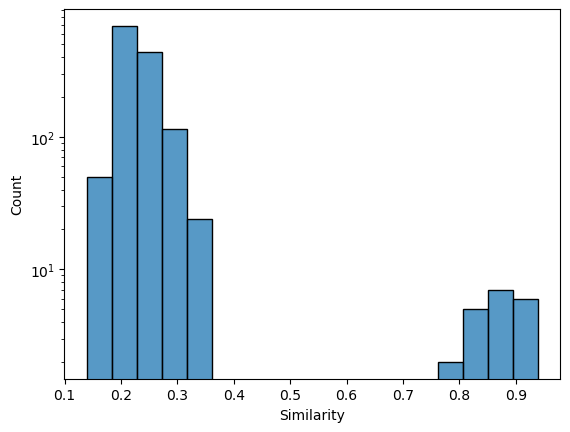

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_recs['Similarity']**0.5,
             bins='doane')
plt.yscale('log')
plt.show()